# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torchtext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
sys.path.append("../")
from Utils.nlp import get_word_to_index
from Utils.neural_net import TrainLoopText, TextDataset
from Utils.models import LSTMmodel

# Data

## Loading Data

In [3]:
data = pd.read_csv("../Data/multimodal.csv")
data['Caption'] = data['Caption'].apply(ast.literal_eval)

## Train Test Split

In [4]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['LABEL'], random_state=1)
train, val = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['LABEL'], random_state=1)

In [5]:
train_text = np.array(train['Caption'])
test_text = np.array(test['Caption'])
val_text = np.array(val['Caption'])

train_label = np.array(train['LABEL'])
test_label = np.array(test['LABEL'])
val_label = np.array(val['LABEL'])

In [6]:
word_to_index = get_word_to_index("../.vector_cache/glove.twitter.27B.25d.txt")

## Custom Dataset preparation

In [7]:
train_set = TextDataset(train_text, train_label, word_to_index)
test_set = TextDataset(test_text, test_label, word_to_index)
val_set = TextDataset(val_text, val_label, word_to_index)

In [8]:
train_loader = DataLoader(train_set, 32)
test_loader = DataLoader(test_set, 32)
val_loader = DataLoader(val_set, 32)

# LSTM Text only model

## Model 1

In [9]:
torch.manual_seed(2)

In [10]:
text_modelv1 = LSTMmodel(4, 25, 256, bidirectionality=True)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv1.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
from tqdm.notebook import tqdm
def TrainLoopText(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader,
    scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    return_best_model:bool=True,
    device:str='cpu'
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    total_train_loss = []
    total_val_loss = []
    best_model_weights = model.state_dict()

    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("\nEpoch {}\n----------".format(epoch))
        train_loss = 0
        for i, batch in enumerate(train_dataloader):
            text_indices = batch['text_indices'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(text_indices)
            loss = criterion(outputs, labels)
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
        total_train_loss.append(train_loss/len(train_dataloader.dataset))

        model.eval()
        validation_loss = 0
        with torch.inference_mode():
            val_true_labels = []
            train_true_labels = []
            val_pred_labels = []
            train_pred_labels = []
            for batch in val_dataloader:
                text_indices = batch['text_indices'].to(device)
                labels = batch['label'].to(device)
                outputs = model(text_indices)
                loss = criterion(outputs, labels)
                validation_loss += loss

                outputs = torch.argmax(outputs, dim=1)
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(outputs.cpu().numpy())

            for batch in train_dataloader:
                text_indices = batch['text_indices'].to(device)
                labels = batch['label'].to(device)
                outputs = model(text_indices)

                outputs = torch.argmax(outputs, dim=1)
                train_true_labels.extend(labels.cpu().numpy())
                train_pred_labels.extend(outputs.cpu().numpy())

            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
                best_model_weights = model.state_dict()
            else:
                epochs_without_improvement += 1

            val_true_labels = np.array(val_true_labels)
            train_true_labels = np.array(train_true_labels)
            val_pred_labels = np.array(val_pred_labels)
            train_pred_labels = np.array(train_pred_labels)

            train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Current Validation Loss = {validation_loss}")
            print(f"Best Validation Loss = {best_val_loss}")
            print(f"Epochs without Improvement = {epochs_without_improvement}")

            print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
        
        total_val_loss.append(validation_loss/len(val_dataloader.dataset))
        scheduler.step(validation_loss)
        
        if epochs_without_improvement == early_stopping_rounds:
            break

    if return_best_model == True:
        model.load_state_dict(best_model_weights)
    total_train_loss = [item.cpu().detach().numpy() for item in total_train_loss]
    total_val_loss = [item.cpu().detach().numpy() for item in total_val_loss]

    total_train_loss = np.array(total_train_loss)
    total_val_loss = np.array(total_val_loss)

    train_accuracies = np.array(train_accuracies)
    val_accuracies = np.array(val_accuracies)

    x_train = np.arange(len(total_train_loss))
    x_val = np.arange(len(total_val_loss))
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    sns.lineplot(x=x_train, y=total_train_loss, label='Training Loss')
    sns.lineplot(x=x_val, y=total_val_loss, label='Validation Loss')
    plt.title("Loss over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(total_train_loss)))
    
    plt.subplot(1,2,2)
    sns.lineplot(x=x_train, y=train_accuracies, label='Training Accuracy')
    sns.lineplot(x=x_val, y=val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(total_train_loss)))

    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.097667932510376
Loss for batch 1 = 1.1018106937408447
Loss for batch 2 = 1.0960149765014648
Loss for batch 3 = 1.081615924835205
Loss for batch 4 = 1.099334955215454
Loss for batch 5 = 1.1081565618515015
Loss for batch 6 = 1.1096361875534058
Loss for batch 7 = 1.0892208814620972
Loss for batch 8 = 1.0873992443084717
Loss for batch 9 = 1.0670220851898193
Loss for batch 10 = 1.1529885530471802
Loss for batch 11 = 1.102056860923767
Loss for batch 12 = 1.103671669960022
Loss for batch 13 = 1.1090586185455322
Loss for batch 14 = 1.0916748046875
Loss for batch 15 = 1.0763286352157593
Loss for batch 16 = 1.092576026916504
Loss for batch 17 = 1.0981913805007935
Loss for batch 18 = 1.0846587419509888
Loss for batch 19 = 1.077620506286621
Loss for batch 20 = 1.067098617553711
Loss for batch 21 = 1.0829699039459229
Loss for batch 22 = 1.0949883460998535
Loss for batch 23 = 1.1004576683044434
Loss for batch 24 = 1.1425501108169556
Loss for batch 25 = 1.1116

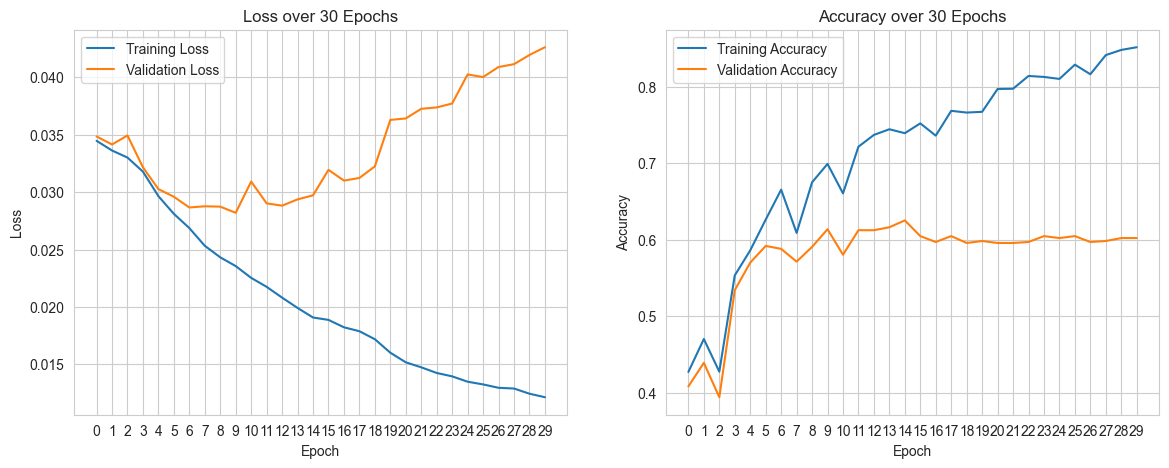

In [12]:
TrainLoopText(text_modelv1, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [13]:
from sklearn.metrics import accuracy_score
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv1(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 60.68%


In [14]:
torch.save(text_modelv1.state_dict(), 'LSTMv1.pth')

## Model 2

In [18]:
torch.cuda.empty_cache()

In [19]:
text_modelv2 = LSTMmodel(3, 25, 512, bidirectionality=True)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv2.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.1009656190872192
Loss for batch 1 = 1.105316162109375
Loss for batch 2 = 1.099278211593628
Loss for batch 3 = 1.0781726837158203
Loss for batch 4 = 1.1139616966247559
Loss for batch 5 = 1.1061747074127197
Loss for batch 6 = 1.1124461889266968
Loss for batch 7 = 1.0931756496429443
Loss for batch 8 = 1.0874216556549072
Loss for batch 9 = 1.0679340362548828
Loss for batch 10 = 1.1731222867965698
Loss for batch 11 = 1.101493239402771
Loss for batch 12 = 1.1018526554107666
Loss for batch 13 = 1.1055727005004883
Loss for batch 14 = 1.0938283205032349
Loss for batch 15 = 1.084906816482544
Loss for batch 16 = 1.0932576656341553
Loss for batch 17 = 1.0975786447525024
Loss for batch 18 = 1.0871587991714478
Loss for batch 19 = 1.0808978080749512
Loss for batch 20 = 1.0676358938217163
Loss for batch 21 = 1.0835015773773193
Loss for batch 22 = 1.0937045812606812
Loss for batch 23 = 1.1027730703353882
Loss for batch 24 = 1.135549545288086
Loss for batch 25 = 

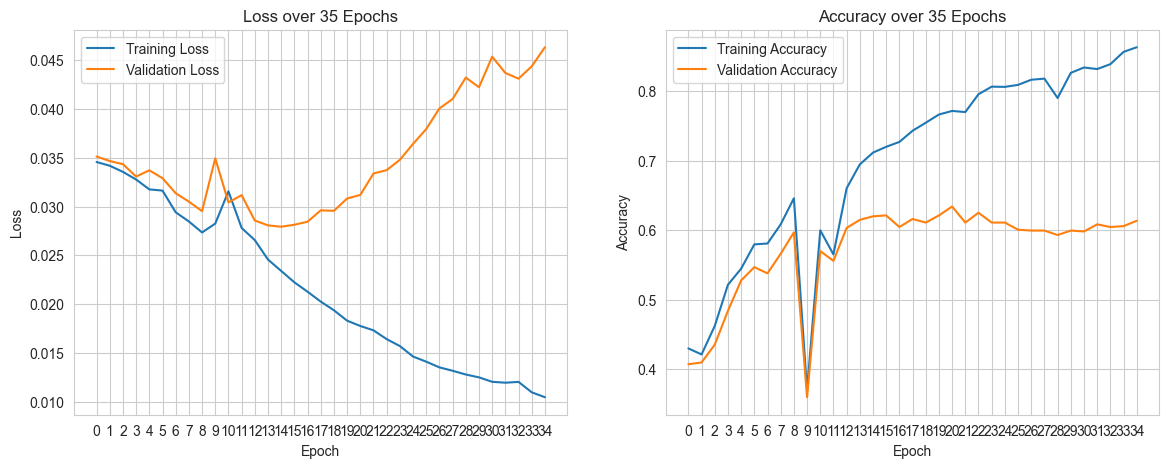

In [20]:
TrainLoopText(text_modelv2, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [1]:
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv2(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

NameError: name 'torch' is not defined

In [22]:
torch.save(text_modelv2.state_dict(), 'LSTMv2.pth')

## Model 3

In [12]:
text_modelv3 = LSTMmodel(4, 25, 256, bidirectionality=True, freeze=True)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv3.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.096352458000183
Loss for batch 1 = 1.1008837223052979
Loss for batch 2 = 1.1001369953155518
Loss for batch 3 = 1.0810010433197021
Loss for batch 4 = 1.1035044193267822
Loss for batch 5 = 1.1053858995437622
Loss for batch 6 = 1.1106619834899902
Loss for batch 7 = 1.0957162380218506
Loss for batch 8 = 1.0877461433410645
Loss for batch 9 = 1.0609874725341797
Loss for batch 10 = 1.1880054473876953
Loss for batch 11 = 1.1047719717025757
Loss for batch 12 = 1.1022535562515259
Loss for batch 13 = 1.1054356098175049
Loss for batch 14 = 1.090705156326294
Loss for batch 15 = 1.0813504457473755
Loss for batch 16 = 1.0923484563827515
Loss for batch 17 = 1.0970937013626099
Loss for batch 18 = 1.0876621007919312
Loss for batch 19 = 1.0764578580856323
Loss for batch 20 = 1.0691678524017334
Loss for batch 21 = 1.0835752487182617
Loss for batch 22 = 1.0935145616531372
Loss for batch 23 = 1.0986700057983398
Loss for batch 24 = 1.142267107963562
Loss for batch 25 

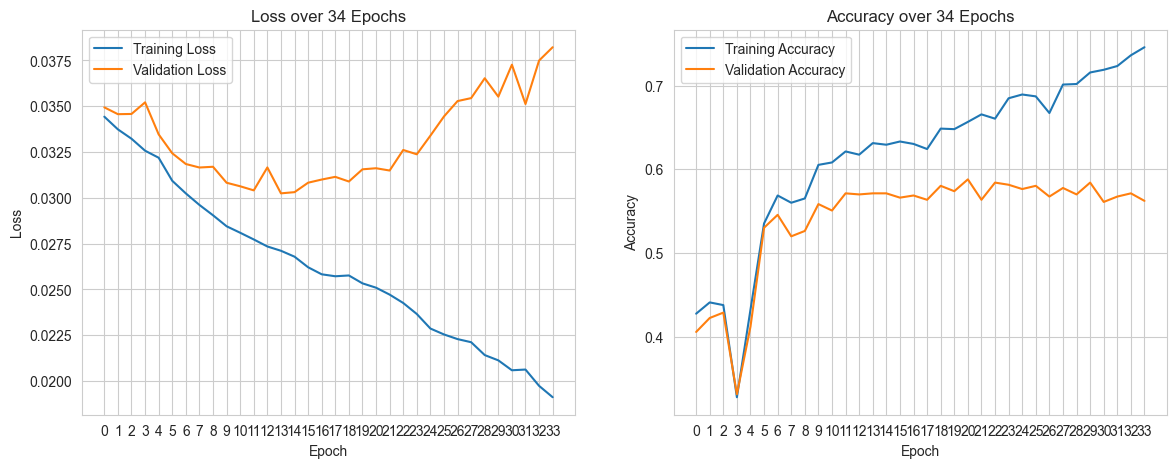

In [13]:
TrainLoopText(text_modelv3, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [14]:
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv3(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 58.11%


## Previous Models

In [16]:
class LSTMmodelv2(torch.nn.Module):
    def __init__(self, n_layers, embed_dim, hidden_dim, embedding:str="twitter.27B", bidirectionality:bool=False) -> None:
        super().__init__()
        glove_embeddings = torchtext.vocab.GloVe(embedding, embed_dim)
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings.vectors, freeze=False)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectionality)
        if bidirectionality == False:
            self.linear = torch.nn.Linear(hidden_dim, 3)
        else:
            self.linear = torch.nn.Linear(2*hidden_dim, 3)

    def forward(self, x):
        a = self.embedding(x)
        a, _ = self.lstm(a)
        a =  a[:,-1,:]
        a = self.linear(a)
        return torch.nn.functional.log_softmax(a, dim=1)

In [20]:
text_modelv4 = LSTMmodelv2(4, 25, 256, bidirectionality=True)
text_modelv4.load_state_dict(torch.load("../Models/lstm11.pth"))

<All keys matched successfully>

In [21]:
true_labels = []
pred_labels = []
text_modelv4.to('cuda')
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv4(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 63.35%


# Redoing Dataset

In [11]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['LABEL'], random_state=3)
train, val = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['LABEL'], random_state=3)
train_text = np.array(train['Caption'])
test_text = np.array(test['Caption'])
val_text = np.array(val['Caption'])

train_label = np.array(train['LABEL'])
test_label = np.array(test['LABEL'])
val_label = np.array(val['LABEL'])
train_set = TextDataset(train_text, train_label, word_to_index)
test_set = TextDataset(test_text, test_label, word_to_index)
val_set = TextDataset(val_text, val_label, word_to_index)
train_loader = DataLoader(train_set, 32)
test_loader = DataLoader(test_set, 32)
val_loader = DataLoader(val_set, 32)

# Modelling new data splits

In [12]:
torch.manual_seed(3)

In [13]:
text_modelv5 = LSTMmodel(4, 25, 256, bidirectionality=True, freeze=False)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv5.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.1016056537628174
Loss for batch 1 = 1.1035573482513428
Loss for batch 2 = 1.100522756576538
Loss for batch 3 = 1.1023117303848267
Loss for batch 4 = 1.103891134262085
Loss for batch 5 = 1.0902734994888306
Loss for batch 6 = 1.1057451963424683
Loss for batch 7 = 1.1012133359909058
Loss for batch 8 = 1.1072429418563843
Loss for batch 9 = 1.0965120792388916
Loss for batch 10 = 1.0863991975784302
Loss for batch 11 = 1.1025625467300415
Loss for batch 12 = 1.0887972116470337
Loss for batch 13 = 1.1037406921386719
Loss for batch 14 = 1.0829473733901978
Loss for batch 15 = 1.1173230409622192
Loss for batch 16 = 1.111648678779602
Loss for batch 17 = 1.10023832321167
Loss for batch 18 = 1.0874381065368652
Loss for batch 19 = 1.0996061563491821
Loss for batch 20 = 1.1191585063934326
Loss for batch 21 = 1.0968074798583984
Loss for batch 22 = 1.0963106155395508
Loss for batch 23 = 1.1032721996307373
Loss for batch 24 = 1.0978889465332031
Loss for batch 25 = 

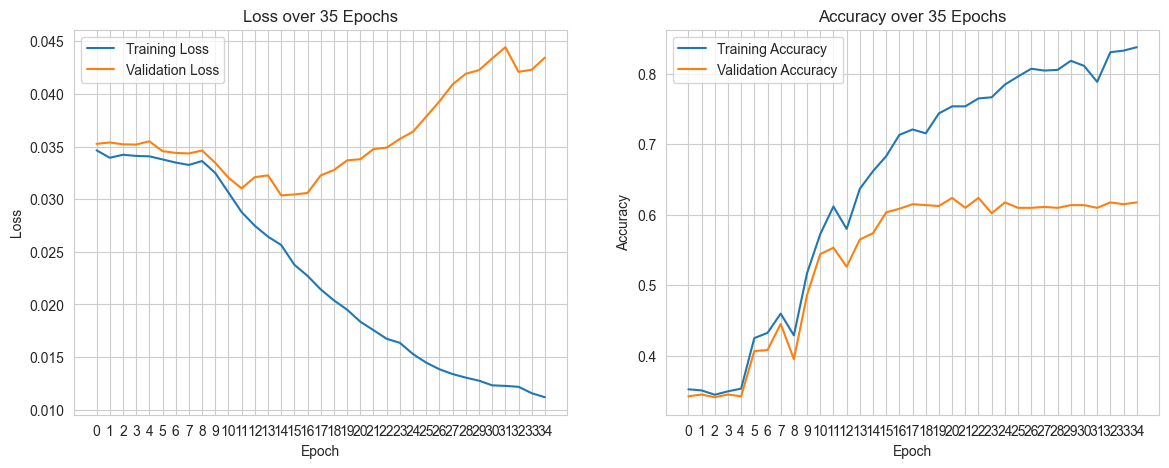

In [14]:
TrainLoopText(text_modelv5, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [16]:
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv5(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 59.75%


C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.0995458364486694
Loss for batch 1 = 1.1070764064788818
Loss for batch 2 = 1.1017833948135376
Loss for batch 3 = 1.1030775308609009
Loss for batch 4 = 1.1020548343658447
Loss for batch 5 = 1.0915840864181519
Loss for batch 6 = 1.1061722040176392
Loss for batch 7 = 1.101550817489624
Loss for batch 8 = 1.1057859659194946
Loss for batch 9 = 1.0973962545394897
Loss for batch 10 = 1.0887336730957031
Loss for batch 11 = 1.1021159887313843
Loss for batch 12 = 1.0891231298446655
Loss for batch 13 = 1.104174256324768
Loss for batch 14 = 1.0841104984283447
Loss for batch 15 = 1.1168212890625
Loss for batch 16 = 1.1103835105895996
Loss for batch 17 = 1.0997503995895386
Loss for batch 18 = 1.0886342525482178
Loss for batch 19 = 1.0996333360671997
Loss for batch 20 = 1.1186861991882324
Loss for batch 21 = 1.0967698097229004
Loss for batch 22 = 1.0959604978561401
Loss for batch 23 = 1.1032906770706177
Loss for batch 24 = 1.0978248119354248
Loss for batch 25 = 

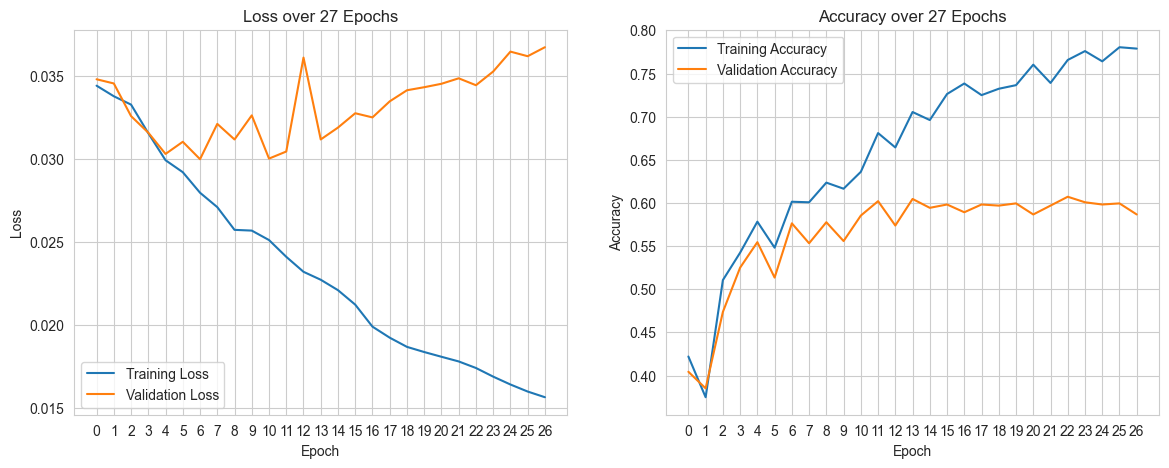

In [17]:
text_modelv6 = LSTMmodel(4, 25, 256, bidirectionality=True, freeze=False)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(text_modelv6.parameters(), 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.4, 8)
TrainLoopText(text_modelv6, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda', return_best_model=False)

In [18]:
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        texts = batch['text_indices'].to('cuda')
        labels = batch['label']
        outputs = text_modelv6(texts)
        preds = torch.argmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

model_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {model_accuracy * 100:.2f}%')

Accuracy: 61.91%


In [20]:
torch.manual_seed(4)